### **가중치 초기값**

In [1]:
from common.utils_nn import sigmoid, relu, softmax, cross_entropy_error
from common.layers import Sigmoid, ReLu, Affine, SoftmaxWithLoss
from collections import OrderedDict, defaultdict

In [2]:
x = np.random.randn(1000, 100) 
node_num=100

def get_activations(x, w_std, node_num, hidden_layer_size=5, function=None):
    """calculate activation value in every hidden layers"""
    activations = {}
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]
            
        w = np.random.randn(node_num, node_num) * w_std
        a = np.dot(x, w)
        z = function(a)
        activations[i] = z
        
    return activations

def draw_figure(activations, title=''):
    """draw histogram"""
    fig = plt.figure(figsize=(11, 4), dpi=100)
    for i, a in activations.items():
        ax = fig.add_subplot(1, len(activations), i+1)
        ax.set_title(str(i+1)+"-layer", loc='center')
        ax.hist(a.flatten(), 30, range=(0,1))
    plt.suptitle(title, fontsize=15, y=1.1)
    plt.tight_layout()
    plt.show()

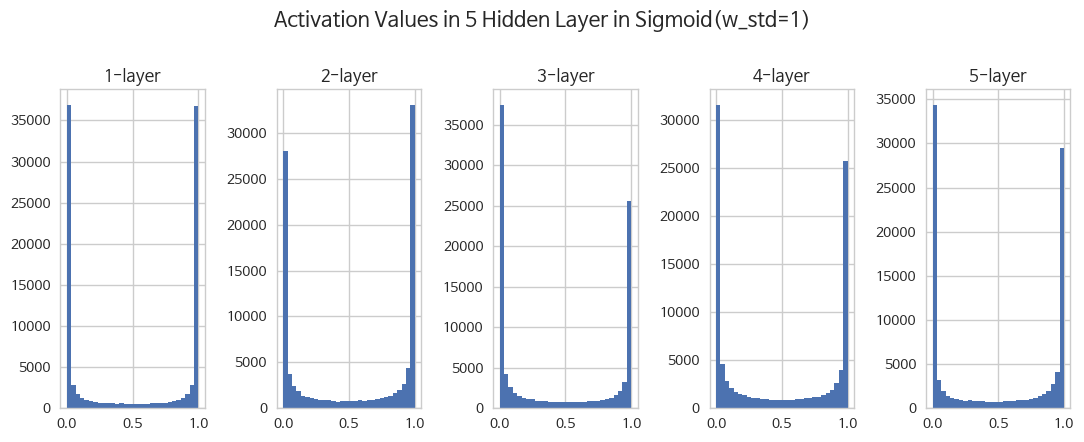

In [14]:
activations = get_activations(x, w_std=1, node_num=node_num, function=sigmoid)
draw_figure(activations, title='Activation Values in 5 Hidden Layer in Sigmoid(w_std=1)')

**기울기 소실(gradient vanishing) 문제:**

Sigmoid에서 활성화 값 분포가 0, 1이 많을 수록 미분값은 0이 많아짐 gradient vanishing 문제 발생

활성 값들의 분포가 0과 1에 치중 되어있다. 이렇게 되면 역전파의 기울기가 점점 작아지다가 소멸된다. 

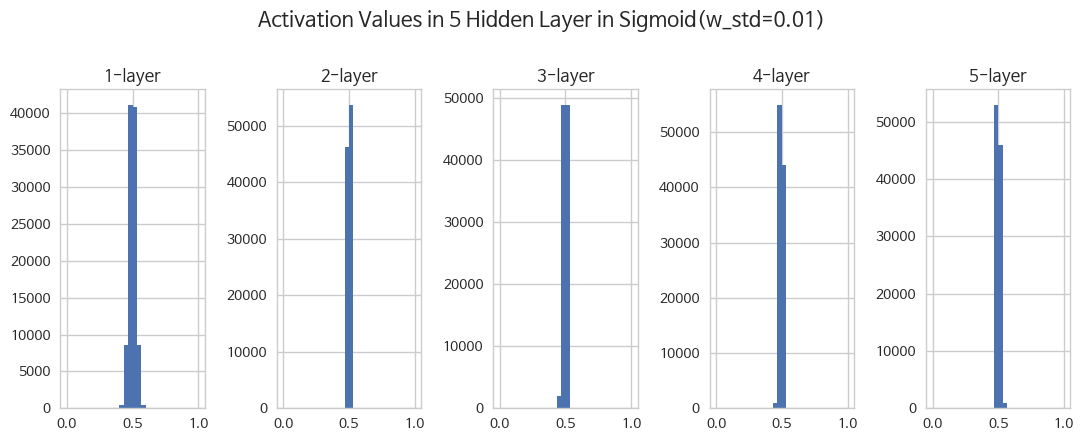

In [91]:
activations = get_activations(x, w_std=0.01, node_num=node_num, function=sigmoid)
draw_figure(activations, title='Activation Values in 5 Hidden Layer in Sigmoid(w_std=0.01)')

표준편차를 0.01로 바꾼후 분포가 0.5로 치우쳤다. 활성화 값들이 치우쳤다는 것은 표현력을 제한하는 것이다.(다수의 뉴런이 거의 같은 값을 출력하고 있으니 뉴런을 여러개 둔 의미가 없어진다는 뜻이다.)

**Xavier 초깃값**

표준편차를 $\frac{1}{\sqrt{n}}$ 으로 초기화 하는 것, 보통 sigmoid, tanh 함수에 쓰인다

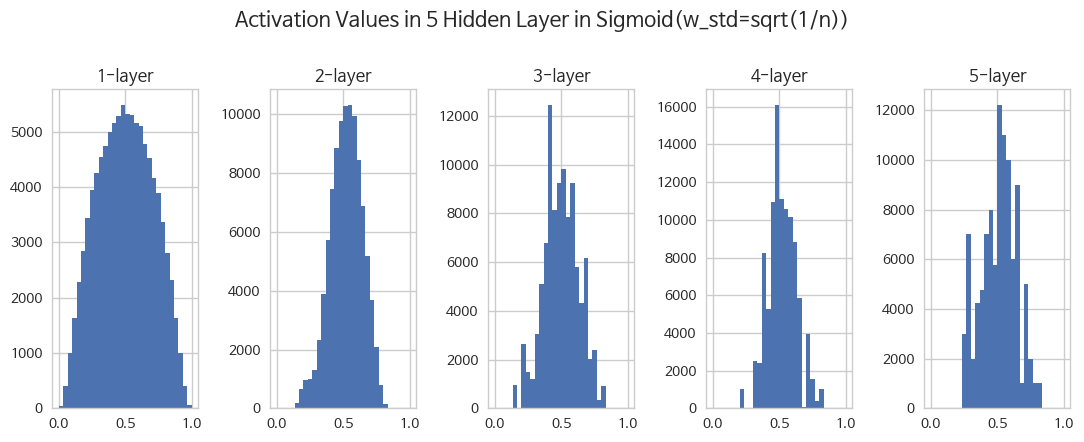

In [89]:
activations = get_activations(x, w_std=(1/np.sqrt(node_num)), node_num=node_num, function=sigmoid)
draw_figure(activations, title='Activation Values in 5 Hidden Layer in Sigmoid(w_std=sqrt(1/n))')

**ReLu 특화된 초기값(He 초기값)**

표준편차를 $\sqrt{\frac{2}{n}}$ 를 사용해야한다

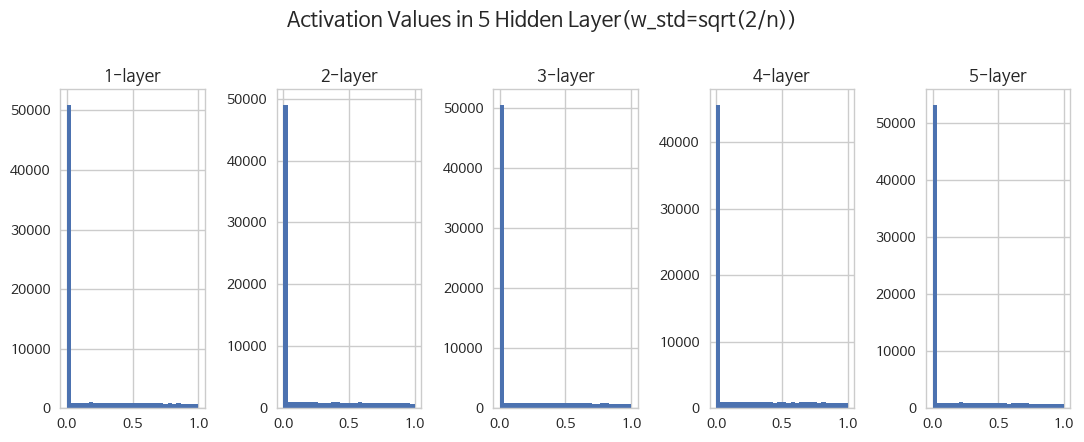

In [87]:
activations = get_activations(x, w_std=np.sqrt(2/node_num), node_num=node_num, function=ReLu)
draw_figure(activations, title='Activation Values in 5 Hidden Layer in ReLu(w_std=sqrt(2/n))')

표준편차를 0.01 썻을 때랑 비교

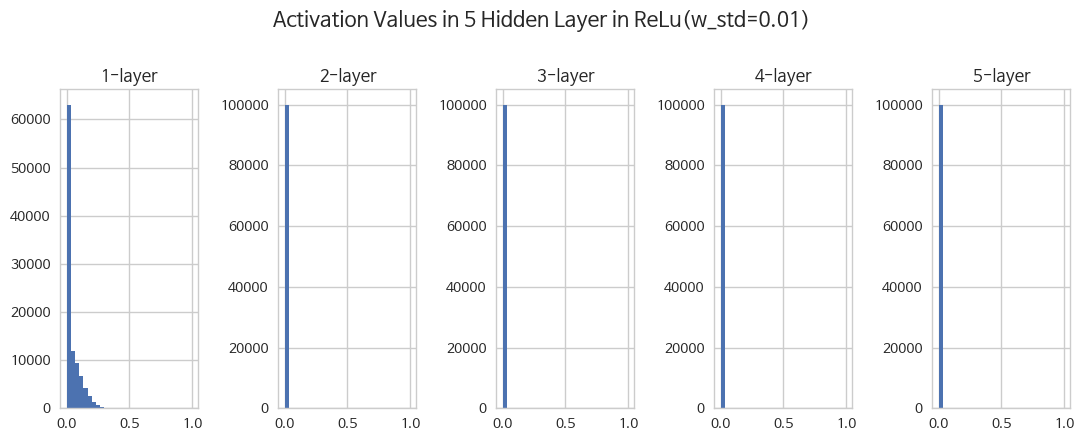

In [88]:
activations = get_activations(x, w_std=0.01, node_num=node_num, function=ReLu)
draw_figure(activations, title='Activation Values in 5 Hidden Layer in ReLu(w_std=0.01)')

In [2]:
def weight_init(w_std, node_num, hidden_layer_size):
    params = {}
    for i in range(hidden_layer_size):
        params['W'+str(i)] = np.random.randn(node_num, node_num) * w_std
        params['b'+str(i)] = np.zeros(node_num)
    return params

def layers_init(params, hidden_layer_size, activation_layer):
    layers = OrderedDict()
    for i in range(hidden_layer_size):
        layers['Affine'+str(i)] = Affine(params['W'+str(i)], params['b'+str(i)])
#         if i != hidden_layer_size-1:
        layers['Activation'+str(i)] = activation_layer()
    return layers
    
def get_activations2(x, t, w_std, node_num, activation_layer, n_epoch=10, hidden_layer_size=5):
    """
    구조
    input: 1000
    hidden1~5: 100
    output: 100
    """
    activations_hist = defaultdict(OrderedDict)
    backwards_hist = defaultdict(OrderedDict)
    # weight init
    params = weight_init(w_std, node_num, hidden_layer_size)
    # layer setting
    layers = layers_init(params, hidden_layer_size, activation_layer)
    back_layers = OrderedDict(reversed(list(layers.items())))
    last_layer = SoftmaxWithLoss()
    
    for epoch in range(n_epoch):
        # forward
        for name, layer in layers.items():
            x = layer.forward(x)
            if name[:-1] == 'Activation':
                activations_hist[epoch][name] = x 

        # softmax
        loss = last_layer.forward(x, t)

        # backprop
        dout = 1
        dout = last_layer.backward(dout)
        
        for name, layer in back_layers.items():
            dout = layer.backward(dout)
            if name[:-1] == 'Affine':
                backwards_hist[epoch][name] = layer.dW * 100  # 잘 안보여서 100을 곱해봄

    return activations_hist, backwards_hist

# def draw_activations_graph(hist, epoch, title='', key_act=True, key_show=True):
#     fig = plt.figure(figsize=(11, 4), dpi=100)
#     for i, (name, a) in enumerate(hist[epoch].items()):
        
#         ax = fig.add_subplot(1, len(hist[epoch]), i+1)
#         idx = i+1 if name[:-1] == 'Activation' else len(hist[epoch])-i
#         ax.set_title(str(idx)+"-layer", loc='center')
#         if key_act:
#             ax.hist(a.flatten(), 30, range=(0,1))
#         else:
#             ax.hist(a.flatten(), 30, range=(-1,1))
#     plt.suptitle(str(epoch) + ": " + title, fontsize=15, y=1.1)
#     plt.tight_layout()
#     if key_show:
#         plt.show()
#     else:
#         plt.close()
#         return fig
    

In [9]:
from matplotlib import animation, rc
import matplotlib.pylab as plt
rc('animation', html='html5')

def draw_animation(hist, key_act=True, subtitle=''):
    title = 'activations' if key_act else 'dW'
    len_epoch = len(hist)
    len_layer = len(hist[0])

    fig = plt.figure(figsize=(11, 4), dpi=100)
    axs = []
    axs.append(fig.add_subplot(111))
    for i in range(len_layer):
        ax = fig.add_subplot(1, len_layer, i+1)
        axs.append(ax)

    axs[0].grid(False)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_frame_on(False)

    ax_dict = defaultdict(list)
    for epoch, v in hist.items():
        for name, data in v.items():
            ax_dict[name].append(data)
    data_list = []
    for d in ax_dict.values():
        data_list.append(d)
    del ax_dict
    
    def ani_update(i):
        for k, ax in enumerate(axs[1:]):
            ax.clear()
            data = data_list[k][i].flatten()
            idx = k + 1 if key_act else len_layer - k
            rng = (0, 1) if key_act else (-0.25, 0.25)
            ax.hist(data, 50, range=rng)
            ax.set_title(str(idx)+"-layer", loc='center')
            ax.grid(False)
        axs[0].set_title('epoch {}: {} values {}'.format(i, title, subtitle), loc='center', fontsize=15, y=1.1)
        fig.tight_layout()
    anim = animation.FuncAnimation(fig, ani_update, frames=len_epoch, interval=200)
    plt.close()
    return anim

def get_anim_list(h_dict, key_act=True):
    anim_list = []
    for s, x in h_dict.items():
        anim = draw_animation(x, key_act=key_act, subtitle='w_std={}'.format(s))
        anim_list.append(anim)
        
    return anim_list

In [10]:
x = np.random.rand(1000, 100)
# t = np.ones(1000, dtype=int)
# t[:500] = 2
t = np.random.randint(0, 100, size=(1000), dtype=int)
node_num=100
hidden_layer_size = 5
activation_layer = Sigmoid
w_std_list = [1, 0.01, 1/np.sqrt(node_num)]
w_std_strings = ['1', '0.01', 'sqrt(1/n)']
a_hists = {s: None for s in w_std_strings}
b_hists = {s: None for s in w_std_strings}

for w_std, s in zip(w_std_list, w_std_strings):
    a, b = get_activations2(x, t, w_std, node_num, activation_layer, n_epoch=20, hidden_layer_size=5)
    a_hists[s] = a
    b_hists[s] = b
    
activations_list = get_anim_list(a_hists, key_act=True)
backwards_list = get_anim_list(b_hists, key_act=False)

In [ ]:
activations_list[0]

In [ ]:
backwards_list[0]

In [ ]:
activations_list[1]

In [ ]:
backwards_list[1]

In [ ]:
activations_list[2]

In [ ]:
backwards_list[2]

ReLu

In [17]:
x = np.random.randn(1000, 100)
t = np.random.randint(0, 100, size=(1000), dtype=int)
# t = np.ones(1000, dtype=int)
# t[:500] = 2
node_num=100
hidden_layer_size = 5
activation_layer = ReLu
w_std_list = [1, 0.01, np.sqrt(2/node_num)]
w_std_strings = ['1', '0.01', 'sqrt(2/n)']
a_hists = {s: None for s in w_std_strings}
b_hists = {s: None for s in w_std_strings}

for w_std, s in zip(w_std_list, w_std_strings):
    a, b = get_activations2(x, t, w_std, node_num, activation_layer, n_epoch=20, hidden_layer_size=5)
    a_hists[s] = a
    b_hists[s] = b
    
activations_list = get_anim_list(a_hists, key_act=True)
backwards_list = get_anim_list(b_hists, key_act=False)

In [ ]:
activations_list[0]

In [ ]:
backwards_list[0]

In [ ]:
activations_list[1]

In [ ]:
backwards_list[1]

In [ ]:
activations_list[2]

In [ ]:
backwards_list[2]

### **배치 정규화**
미내비치 단위로 정규화한다. 데이터 분포가 평균이 0 분산이 1이 되도록 한다., 데이터 분포가 덜 치우치게 하는 효과 있음(큰 값에 의존 덜하게)

**장점:**
* 학습을 빨리 진행 할 수 있다(학습 속도 개선).
* 초깃값에 크게 의존하지 않는다.
* 오버피팅을 억제한다(드롭아웃 등의 필요성 감소).

$$
\mu_{B} \leftarrow \frac{1}{m}\sum_{i=1}^{m}{x_i} \\
\\ 
\sigma_{B}^{2} \leftarrow \frac{1}{m}\sum_{i=1}^{m}{(x_i - \mu_B)^2} \\
\\
\hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_{B}^{2} + \varepsilon}}
$$
$B$ 는 미니배치다.

배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대(scale)와 이동(shift)변환을 수행한다.

$$y_i \leftarrow \gamma \hat{x_i}+\beta$$

$Affine \rightarrow BatchNorm \rightarrow ReLu$ 이런식으로 계속 감

![](./figs/NN_batchnorm.png)

In [ ]:
class BatchNormalization(object):
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

In [29]:
from common.layers import Sigmoid, ReLu

In [30]:
sig = Sigmoid()
relu = ReLu()

In [11]:
x = np.linspace(-5, 5, 100)
y = sig.forward(x)
dout=1
grads = sig.backward(dout)

In [33]:
x = np.linspace(-5, 5, 100)
y = relu.forward(x)
dout=np.ones_like(y)
grads = relu.backward(dout)

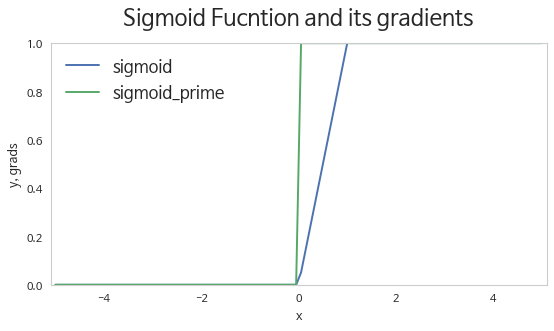

In [35]:
plt.figure(figsize=(8, 4), dpi=80)
plt.plot(x, y, 'b-', label='sigmoid')
plt.plot(x, grads, 'g-', label='sigmoid_prime')
plt.xlabel('x')
plt.ylabel('y, grads')
plt.xlim((-5.1, 5.1))
plt.ylim((0, 1))
plt.legend(loc='upper left', fontsize=15)
plt.title('Sigmoid Fucntion and its gradients', fontsize=20, y=1.05)
plt.grid(False)
plt.show()